# Homework4: Denoising score matching

## Task 1: Theory (5pt)

### Problem 1: Implicit score matching (2pt)

We have discussed score matching task at Lectures [7](https://github.com/r-isachenko/2025-DGM-MIPT-YSDA-course/blob/main/lectures/lecture7/Lecture7.pdf) and [8](https://github.com/r-isachenko/2025-DGM-MIPT-YSDA-course/blob/main/lectures/lecture8/Lecture8.pdf). The objective of score matching is
$$
    \frac{1}{2} \mathbb{E}_{\pi}\bigl\| \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}) - \nabla_\mathbf{x} \log \pi(\mathbf{x}) \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}.
$$

And we have already known one possible solution for this task. It is denoising score matching.

Here our goal is to derive one more way to solve the initial score matching problem. It is called **implicit score matching**.

Let consider 1-d case ($x \in \mathbb{R}$).
Prove that
$$
\frac{1}{2} \mathbb{E}_{\pi}\bigl\| s_{\boldsymbol{\theta}}(x) - \nabla_x \log \pi(x) \bigr\|^2_2 = \mathbb{E}_{\pi}\left[ \frac{1}{2}s^2_{\boldsymbol{\theta}}(x) + \nabla_{x} s_{\boldsymbol{\theta}}(x) \right] + \text{const}.
$$

- **Question:** Why is the expression at the right hand side better than the left one? 
  
  **Answer:** It is better because we do not have the term with the unknown distribution $\pi(x)$.

- **Question:** Why do we not use this expression instead of denoising score matching? 

  **Answer:** In this expression we have term $\nabla_{x} s_{\boldsymbol{\theta}}(x) = \nabla^2_{x} \log p(x | \boldsymbol{\theta})$. And it is difficult to work with the second derivates.

- **Question:** Why do we consider only 1-d case? 

  **Answer:** It is very straightforward to generalize this formula to the multidimensional case, but the derivation contains much more formulas.

```
your solution
```

### Problem 2: Conditioned reverse distribution for NCSN (3pt)

The distribution $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0)$ plays the crucial role in the DDPM.

Find the parameters of this Normal distribution for the NCSN Markov chain $\mathbf{x}_t = \mathbf{x}_0 + \sigma_t \cdot \boldsymbol{\epsilon}$.

**Note:** in this case the mean should be the convex combination of $\mathbf{x}_t$ and $\mathbf{x}_0$ (this differs from the DDPM Markov chain).

```
your solution
```

In [ ]:
COMMIT_HASH = "79dfd7865ba692235f0a4d5aed20ee2820a19007"
!if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!pip install ./
%cd ./..
!rm -Rf dgm_utils

In [2]:
from dgm_utils import train_model
from dgm_utils import show_samples, visualize_images, load_dataset, visualize_2d_data, visualize_2d_samples
from dgm_utils import BaseModel

In [ ]:
import numpy as np
from typing import Tuple, List
import math

import torch
import torch.nn as nn
import torch.utils.data as data
from torch.nn import functional as F

if torch.cuda.is_available():
    DEVICE = "cuda"
    print('GPU found :)')
else:
    DEVICE = "cpu"
    print('GPU not found :(')

## Task 2: Denoising score matching for 2D data (5 pts)

In this task you will implement the denoising score matching model to the 2D moons dataset.

Let's take a look at dataset samples.

In [ ]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = load_dataset('moons', size=COUNT, with_targets=True)
visualize_2d_data(train_data, test_data, train_labels, test_labels)

Let recall the theory of denoising score matching.

The idea is the following. We define the score function
$$
    \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}) = \nabla_{\mathbf{x}}\log p(\mathbf{x}| \boldsymbol{\theta}).
$$

Then we minimize the Fisher divergence to obtain the score function:
$$
    D_F(\pi, p) = \frac{1}{2}\mathbb{E}_{\pi}\bigl\| \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}) - \nabla_{\mathbf{x}} \log \pi(\mathbf{x}) \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}
$$.

If we had the score function, we could use the Langevin dynamics to sample from our model:
$$
    \mathbf{x}_{l + 1} = \mathbf{x}_l + \frac{\eta}{2} \cdot \nabla_{\mathbf{x}_l} \log p(\mathbf{x}_l | \boldsymbol{\theta}) + \sqrt{\eta} \cdot \boldsymbol{\epsilon}, \quad \boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I}).
$$

However, Fisher divergence is intractable and we use the noising procedure to get noised samples $\mathbf{x}_{\sigma} = \mathbf{x} + \sigma \cdot \boldsymbol{\epsilon}$.

Minimizing the Fisher divergence for the noisy samples is equivalent to the following objective:
$$
\mathbb{E}_{q(\mathbf{x}_{\sigma})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_{\sigma}) \bigr\|^2_2 = \mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_{\sigma} | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_{\sigma} | \mathbf{x}) \bigr\|^2_2 + \text{const}(\boldsymbol{\theta}).
$$

Here
$$
    \log q(\mathbf{x}_{\sigma} | \mathbf{x}) = - \frac{\mathbf{x}_{\sigma} - \mathbf{x}}{\sigma^2} = - \frac{\boldsymbol{\epsilon}}{\sigma}.
$$

Therefore, the objective of the denoising score matching is

$$
\mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_{\sigma} | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) + \frac{\boldsymbol{\epsilon}}{\sigma} \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}.
$$

In [ ]:
class DenoisingScoreMatcher(BaseModel):
    def __init__(
            self,
            score_model: nn.Module,
            input_shape: Tuple[int],
            sigma: float
        ):
        super().__init__()

        self.score_model = score_model
        self.input_shape = input_shape
        self.sigma = sigma

    def forward(self, x: torch.Tensor):
        # ====
        # your code
        # sample gaussian noise
        # perturb samples using the noise and sigma

        # =====

        # calculate the score model
        s = self.score_model(noisy_x)

        # ====
        # your code
        # compute the loss
        # it is mse between score function and gradient of the normal distribution

        # =====
        return loss

    def loss(self, x: torch.Tensor):
        return {"total_loss": self(x).mean(dim=0).sum()}

    def langevin_dynamics(self, x: torch.Tensor, num_steps: int, eta: float):
        # =====
        # your code
        # apply Langevin dynamics in for-cycle to the starting point x
        
        # =====
        return x

    def sample(self, num_samples: int = 64, num_steps: int=100, eta: float = 0.01):
        with torch.no_grad():
            # we sample x_0 from U[-1, 1]
            x0 = 2. * torch.rand_like(torch.empty(num_samples, *self.input_shape)) - 1.
            x0 = x0.to(self.device)

            # run langevine dynamics
            x = self.langevin_dynamics(x0, num_steps=num_steps, eta=eta)
        return x


def test_denoiser_score_matcher():
    matcher = DenoisingScoreMatcher(
        score_model=nn.Linear(2, 2),
        input_shape=(2,),
        sigma=0.1
    )
    x = torch.rand(16, 2)
    assert x.size() == matcher(x).size()
    loss = matcher.loss(x)["total_loss"]
    assert len(loss.size()) == 0
    assert list(matcher.sample(4).size()) == [4, 2]


test_denoiser_score_matcher()

That's all!

And now we are ready to train our model.

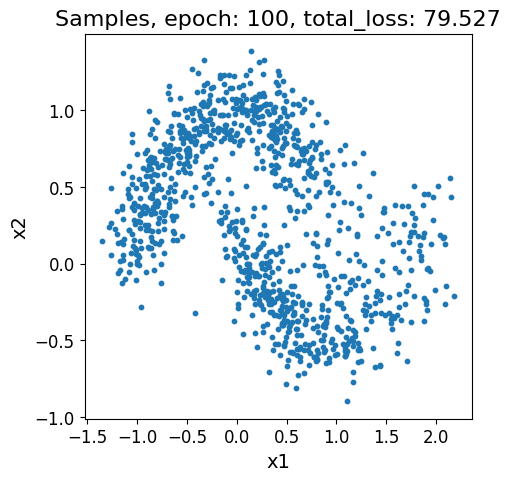

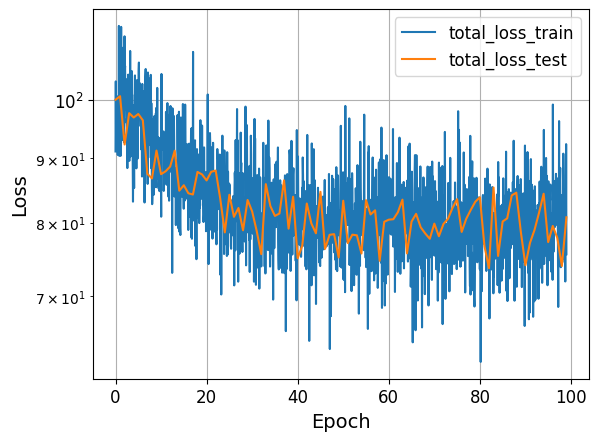

End of the training


In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE =  
EPOCHS = 
LR = 
HIDDEN_SIZE = 
SIGMA = 
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# ====
# your code
# define sequential model
# it is enough to use the sequence of Linear layers with activations

# ====

matcher = DenoisingScoreMatcher(
    score_model=score_model, input_shape=(2,), sigma=SIGMA
)

# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(matcher.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

train_model(
    matcher,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    n_samples=1024,
    visualize_samples=True,
    logscale_y=True,
)

Let sample from our model. Experiment with number of steps and $\eta$ for Langevin dynamics.

In [ ]:
# ====
# your code
# choose these parameters
NUM_STEPS = 
ETA = 
# ====

samples = matcher.sample(num_samples=5000, num_steps=NUM_STEPS, eta=ETA).cpu()

visualize_2d_samples(samples, title="Samples", s=1)

## Task 3: Noise Conditioned Score Network for MNIST (5 pts)

Now we try to extend our model to the NCSN. It means that we have to add multiple noise scales.

**Note!** Here we rescale the images to $[-1, 1]$, which will help us with training of the NCSN.

In [ ]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=False)
visualize_images(train_data, "MNIST samples")

train_data, test_data = 2 * train_data - 1, 2 * test_data - 1

As in seminar [8](https://github.com/r-isachenko/2025-DGM-MIPT-YSDA-course/blob/main/seminars/seminar8) we will use UNet - a standart choice for all family of diffusion models. We'll begin with a simple implementation (`nn.GroupNorm` and `nn.Embedding`) and progressively enhance it with advanced components in future homeworks.

First, we'll define the UNet's core component. It is the `ResBlock`, which enhances standard ResNet blocks with timestep embeddings.

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_dim, dropout):
        super().__init__()
             
        self.temb_proj = nn.Sequential(nn.SiLU(), nn.Linear(t_dim, out_channels))

        # ====
        # your code
        # create two convolutional blocks of nn.Sequential
        # first block should take raw input
        # second block should take the output of the first block with added time and class embeddings
        # it is preferrable to use nn.GroupNorm (~8 groups), nn.SiLU and nn.Dropout

        # ====

        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x, temb):
        # ====
        # your code
        # 1) pass x through the first block
        # 2) add time embedding (unsqueeze it to the right shape)
        # 3) pass the result through the second block
        # 4) add the shortcut
        
        # ====
        return h

The `DownsampleBlock` and `UpsampleBlock` implement the UNet's characteristic encoder-decoder structure, managing resolution changes as features flow through the network.

In [ ]:
class DownsampleBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        # ====
        # your code 
        # define convolutional layer that:
        # 1) does not change the number of channels
        # 2) reduces the size of the image twice
        
        # ====

    def forward(self, input_tensor: torch.Tensor, *args) -> torch.Tensor:
        # ====
        # your code
        
        # ====
        return x

class UpsampleBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        # ====
        # your code 
        # define convolutional layer that:
        # 1) does not change the number of channels
        # 2) does not reduce the size of the image
        
        # ====

    def forward(self, input_tensor: torch.Tensor, *args) -> torch.Tensor:
        # ====
        # your code
        # 1) upsample the input tensor using bilinear interpolation
        # 2) pass the result through the convolutional layer
        
        # ====
        return x

Finally, we define the complete `UNet` - the neural network backbone of our diffusion model that handles both encoding and decoding with skip connections. Look at the code carefully.

In [11]:
class UNet(nn.Module):
    def __init__(
        self, 
        num_timesteps: int, 
        hidden_channels: int, 
        channel_multipliers: List[int], 
        num_blocks: int = 1,
        dropout: float = 0.1
    ):
        super().__init__()
        
        temb_dim = hidden_channels * 4
        self.time_embedding = nn.Embedding(num_timesteps, temb_dim)
        self.head = nn.Conv2d(1, hidden_channels, kernel_size=3, stride=1, padding=1)
        channel_list, curr_channels = [hidden_channels], hidden_channels

        # initialization of downsample blocks
        self.downsample_blocks = nn.ModuleList()
        for idx, scale in enumerate(channel_multipliers):
            out_channels = hidden_channels * scale
            is_last = (idx == len(channel_multipliers) - 1)

            # make multiple ResBlocks at each scale
            for _ in range(num_blocks):
                # at each channel_multipliers scale we add ResBlock
                # last block has attention
                self.downsample_blocks.append(
                    ResBlock(curr_channels, out_channels, temb_dim, dropout)
                )
                curr_channels = out_channels
                channel_list.append(curr_channels)

            # add downsample block if not last block
            if not is_last:
                self.downsample_blocks.append(DownsampleBlock(curr_channels))
                channel_list.append(curr_channels)
        
        # initialization of bottleneck block
        self.bottleneck = nn.ModuleList([
            ResBlock(curr_channels, curr_channels, temb_dim, dropout),
            ResBlock(curr_channels, curr_channels, temb_dim, dropout)
        ])
        
        # initialization of upsample blocks
        self.upsample_blocks = nn.ModuleList()
        for idx, scale in reversed(list(enumerate(channel_multipliers))):
            out_channels = hidden_channels * scale
            is_first, is_last = (idx == 0), (idx == len(channel_multipliers) - 1)

            # make multiple ResBlocks at each scale
            for _ in range(num_blocks + 1):
                # at each reverse channel_multipliers scale we add ResBlock
                # first block has attention
                self.upsample_blocks.append(
                    ResBlock(channel_list.pop() + curr_channels, out_channels, temb_dim, dropout)
                )
            
                curr_channels = out_channels
            
            # add upsample block if not last block
            if not is_first:
                self.upsample_blocks.append(UpsampleBlock(curr_channels))
                
        self.tail = nn.Sequential(
            nn.GroupNorm(8, curr_channels),
            nn.SiLU(),
            nn.Conv2d(curr_channels, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x, t):
        temb = self.time_embedding(t)

        h = self.head(x)
        skip_connections = [h] # save intermediate results for skip connections

        # downsample
        for layer in self.downsample_blocks:
            h = layer(h, temb)
            skip_connections.append(h) # save intermediate results for skip connections

        # bottleneck
        for layer in self.bottleneck:
            h = layer(h, temb)
        
        # upsample
        for layer in self.upsample_blocks:
            if isinstance(layer, ResBlock): # apply skip connection
                skip_connection = skip_connections.pop()
                h = torch.cat([h, skip_connection], dim=1)
            h = layer(h, temb)

        h = self.tail(h)
        return h

def test_unet():
    model = UNet(
        num_timesteps=10, 
        hidden_channels=128, 
        channel_multipliers=[1, 2, 4],
        num_blocks=2 
    )
    x = torch.rand((2, 1, 32, 32))
    t = torch.zeros(size=(2,), dtype=torch.long)
    out1 = model(x, t)
    t = torch.ones(size=(2,), dtype=torch.long)
    out2 = model(x, t)
    assert not np.allclose(out1.detach().numpy(), out2.detach().numpy())


test_unet()

Now lets define the main model.

We will use the sequence of the noise levels: $\sigma_1 < \sigma_2 < \dots < \sigma_T$. In this task it will be the geometric progression.
And we will perturb the original data with the different noise levels to obtain 
$$
\mathbf{x}_t = \mathbf{x} + \sigma_t \cdot \boldsymbol{\epsilon}, \quad \mathbf{x}_t \sim q(\mathbf{x}_t). 
$$

Our training objective:
$$
    \sum_{t=1}^T \frac{\sigma_t^2}{\sigma_T^2} \mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_t | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma_t}(\mathbf{x}_t) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_t | \mathbf{x}) \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}
$$
But instead of doing the honest summation we will sample one timestamp for each sample.

We will use annealed Langevin dynamics to sample from our model:
1. Sample $\mathbf{x}_0 \sim \mathcal{N}(0, \sigma_T^2 \cdot \mathbf{I}) \approx q(\mathbf{x}_T)$.
2. Apply $L$ steps of Langevin dynamic
$$
    \mathbf{x}_l = \mathbf{x}_{l-1} + \frac{\eta_t}{2} \cdot \mathbf{s}_{\boldsymbol{\theta}, \sigma_t}(\mathbf{x}_{l - 1}) + \sqrt{\eta_t} \cdot \boldsymbol{\epsilon}_l.
$$
3. Update $\mathbf{x}_0 := \mathbf{x}_L$ and choose the next $\sigma_t$.
4. Repeat it for all sigmas.

**Note:** use the following formula for $\eta_t = \epsilon \cdot \frac{\sigma_t^2}{\sigma_T^2}$ ($\epsilon$ is a small number that is a hyperparameter of the sampling).

In [ ]:
class NoiseConditionedScoreNetwork(BaseModel):
    def __init__(
            self,
            input_shape: Tuple[int, int],
            sigmas: List[float],
            hidden_channels: int,
            channel_multipliers: List[int],
            num_blocks: int
        ):
        super().__init__()

        self.score_model = UNet(
            num_timesteps=len(sigmas), 
            hidden_channels=hidden_channels, 
            channel_multipliers=channel_multipliers, 
            num_blocks=num_blocks
        )
        self.input_shape = input_shape
        self.sigmas = torch.FloatTensor(sorted(sigmas, reverse=True))

    def forward(self, x: torch.Tensor):
        self.sigmas = self.sigmas.to(self.device)
        batch_size = x.shape[0]
        # ====
        # your code
        # sample gaussian noise
        # sample timestamps for each datapoint in the batch
        # choose sigmas for these datapoints
        # add noises to the x samples
        
        # =====

        # calculate the score model
        s = self.score_model(noisy_x, which_sigmas)

        # ====
        # your code
        # compute the loss
        # it is mse between score function and gradient of the normal distribution (do not forget the coefficient before the mse)
        
        # =====
        return loss

    def loss(self, x: torch.Tensor):
        return {"total_loss": self(x).mean(dim=0).sum()}

    def annealed_langevin_dynamics(self, x: torch.Tensor, num_steps: int, eps: float):
        # =====
        # your code
        # here we will have 2 cycles: one for sigmas, one for Langevin sampling
        # start with the largest sigma, apply Langevin dynamic for it and move to the next sigma
        
        # =====
        return x
    @torch.no_grad()
    def sample(self, num_samples: int = 64, num_steps: int=10, eps: float = 0.1):
        # we sample x_0 from U[-1, 1]
        x0 = 2. * torch.rand_like(torch.empty(num_samples, *self.input_shape)) - 1.
        x0 = x0.to(self.device)

        # run langevine dynamics
        x = self.annealed_langevin_dynamics(x0, num_steps=num_steps, eps=eps)
        return (x.clip(-1., 1) + 1) / 2


def test_ncsn():
    ncsn = NoiseConditionedScoreNetwork(
        input_shape=(1, 8, 8),
        sigmas=[0.1],
        hidden_channels=64,
        channel_multipliers=[1, 2],
        num_blocks=1
    )
    x = torch.rand((2, 1, 8, 8))
    assert x.size() == ncsn(x).size()
    loss = ncsn.loss(x)["total_loss"]
    assert len(loss.size()) == 0
    assert list(ncsn.sample(4).size()) == [4, 1, 8, 8]


test_ncsn()

Epoch: 20, loss: 45.27331782912395


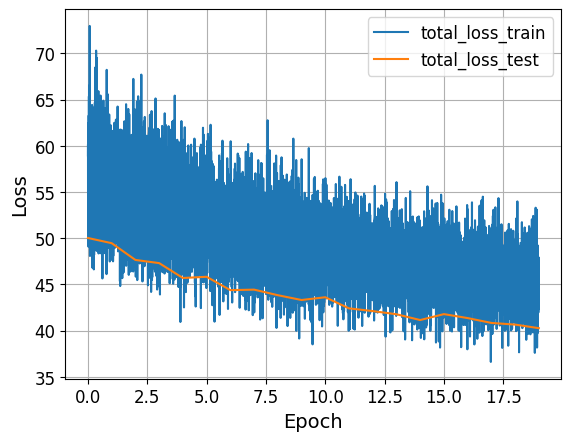

End of the training


In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 
LR = 
EPOCHS = 
HIDDEN_CHANNELS = 
CHANNEL_MULTIPLIERS = 
NUM_BLOCKS = 

sigma_max = 
sigma_min = 
L = 
SIGMAS = 
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

ncsn = NoiseConditionedScoreNetwork(
    input_shape=(1, 32, 32), sigmas=SIGMAS, 
    hidden_channels=HIDDEN_CHANNELS, 
    channel_multipliers=CHANNEL_MULTIPLIERS,
    num_blocks=NUM_BLOCKS
)

# choose any optimizer/scheduler as you want
optimizer = torch.optim.AdamW(ncsn.parameters(), lr=LR, betas=(0.9, 0.999), weight_decay=1e-3)

# train
train_model(
    ncsn,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    n_samples=16,
    visualize_samples=False # probably you don't want to visualize samples, since it takes a lot of time
)

Now you can try to select proper inference parameters to obtain better images.

Unfortunately, inference with this class of models is computationally intensive and slow. Generating 100 images requires approximately 5 minutes on a GTX 1080 Ti GPU :(

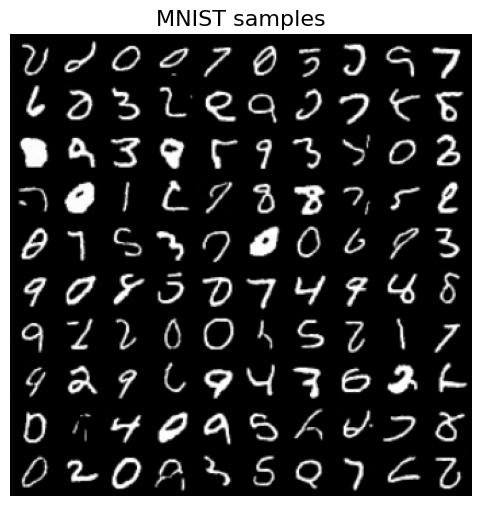

In [ ]:
# ====
# your code
# choose these parameters
NUM_STEPS = 
EPS = 
# ====

samples = ncsn.sample(100, num_steps=NUM_STEPS, eps=EPS).cpu()
show_samples(samples, "MNIST samples")